In [1]:
import tensorflow as tf
import numpy as np
import os
from skimage import io
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

def load_and_split_image(image_path, img_size=(192, 288)):
    # Load full image (380, 1140, 3)
    full_image = io.imread(image_path)  
    
    # Ensure image is the expected shape
    if full_image.shape[1] < 1140:
        print(f"❌ Error: Image width too small - {image_path}, Shape: {full_image.shape}")
        return None, None

    # Split into B-scan (left) and mask (right)
    bscan = full_image[:, :570, :]  # Left half: OCT B-scan
    mask = full_image[:, 570:, :]   # ✅ Right half: Segmentation mask (Fix applied)

    # Resize to match U-Net input shape
    bscan = tf.image.resize(bscan, img_size)  # (190, 285, 3)
    mask = tf.image.resize(mask, img_size)    # (190, 285, 3)

    return bscan.numpy(), mask.numpy()


In [2]:
# Define color-to-class mapping (RGB values for each class)
COLOR_MAP = {
    (255, 0, 0): 0,       # Red: SRF (class 0)
    (255, 192, 203): 1,   # Pink: IS/OS (class 1)
    (0, 0, 255): 2,       # Blue: PED (class 2)
    (0, 255, 0): 3,       # Green: IRF (class 3)
    (255, 255, 0): 4,     # Yellow: SHRM (class 4)
    (0, 0, 0): 5          # Black: Background (class 5)
}

def rgb_to_label(mask_rgb):
    label_mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    for rgb, class_idx in COLOR_MAP.items():
        # Find pixels matching the RGB color
        matches = np.all(mask_rgb == np.array(rgb), axis=-1)
        label_mask[matches] = class_idx
    return label_mask  # Shape: (190, 285)

In [3]:
def load_dataset_from_txt(txt_path, base_dir="/kaggle/input/amd-sd/AMD-SD/images", img_size=(192, 288)):
    with open(txt_path, "r") as f:
        filenames = [line.strip() for line in f.readlines()]
    
    images = []
    masks = []
    for filename in filenames:
        # Extract eye ID from filename (e.g., "1_1.png" → eye_id = "1")
        eye_id = filename.split("_")[0]
        image_path = os.path.join(base_dir, eye_id, filename)
        
        # Load and split image
        bscan, mask_rgb = load_and_split_image(image_path, img_size)
        
        # Convert mask to class labels
        mask_label = rgb_to_label(mask_rgb)
        
        images.append(bscan)
        masks.append(mask_label)
    
    return np.array(images), np.array(masks)

# Load training and validation data
X_train, Y_train = load_dataset_from_txt("/kaggle/input/amd-sd/AMD-SD/training.txt")
X_val, Y_val = load_dataset_from_txt("/kaggle/input/amd-sd/AMD-SD/validation.txt")

# Normalize images to [0, 1]
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0

# One-hot encode masks (for categorical crossentropy)
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=6)
Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=6)

In [4]:
def unet_model(input_size=(192, 288, 3), num_classes=6):
    inputs = Input(input_size)
    # Encoder
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2), padding="same")(c1)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2), padding="same")(c2)
    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    # Decoder
    u1 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation="relu", padding="same")(u1)
    u2 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(64, (3, 3), activation="relu", padding="same")(u2)
    # Final layer
    outputs = Conv2D(num_classes, (1, 1), activation="softmax", padding="same")(c5)
    
    model = Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [5]:
# Train the model
history = model.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    batch_size=8, 
    validation_data=(X_val, Y_val)
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - accuracy: 0.8914 - loss: 0.3692 - val_accuracy: 0.9344 - val_loss: 0.1663
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9390 - loss: 0.1620 - val_accuracy: 0.9347 - val_loss: 0.1577
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9448 - loss: 0.1422 - val_accuracy: 0.9442 - val_loss: 0.1405
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9480 - loss: 0.1336 - val_accuracy: 0.9490 - val_loss: 0.1293
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9496 - loss: 0.1286 - val_accuracy: 0.9505 - val_loss: 0.1268
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9516 - loss: 0.1235 - val_accuracy: 0.9517 - val_loss: 0.1215
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9527 - loss: 0.1201 - val_accuracy: 0.9502 - val_loss: 0.1230
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9544 - loss: 0.1153 -

In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 192, 288, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 192, 288, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 144, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 144, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 72, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 96, 144, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 144, 128)        │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 192, 288, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 192, 288, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 192, 288, 6)         │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,220,116 (8.47 MB)

 Trainable params: 740,038 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,480,078 (5.65 MB)

In [7]:
# Evaluate on the validation set
results = model.evaluate(X_val, Y_val, verbose=1)
print("Validation Loss:", results[0])
print("Validation Accuracy:", results[1])


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9523 - loss: 0.1194
Validation Loss: 0.11644478887319565
Validation Accuracy: 0.9534845948219299


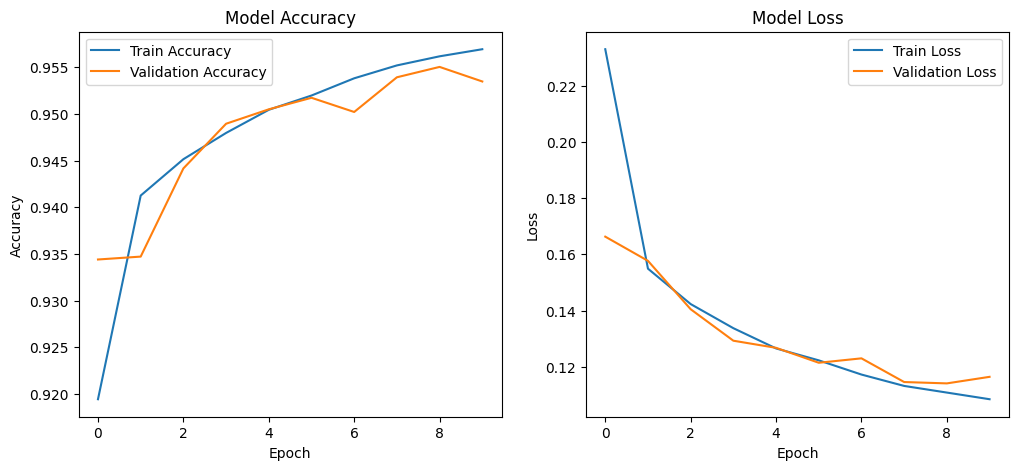

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [9]:
# Choose a sample index from your validation set
idx = 30

# Get the image and ground truth from your validation set
val_image = X_val[idx]
val_ground_truth = np.argmax(Y_val[idx], axis=-1)  # Assuming one-hot encoded labels

# Get the model prediction
prediction = model.predict(np.expand_dims(val_image, axis=0))
predicted_mask = np.argmax(prediction[0], axis=-1)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(val_image), cmap='gray', vmin=0, vmax=1)
plt.title('Validation Image')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(val_ground_truth, cmap='jet')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='jet')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
